<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/4_SHAP_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet fastai==2.2.5
!pip install --quiet shap==0.39.0

In [3]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

# Dataset import

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
data = pd.get_dummies(data)

# Model import

## XGBoost

In [5]:
pd.options.mode.chained_assignment = None
X_test = mf.get_set('test_id', data, 'xgboost_new')

**Importante**: se il modello è trainato su GPU, quando si carica bisogna attivare il runtime con GPU, sennò il modello non vine caricato nel modo corretto. 

In [6]:
load = True
if load:
  from joblib import load
  from xgboost import XGBClassifier

  xgb = load("/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/xgboost_new/xgb_np.joblib.dat")

# SHAP

**Idea**

A prediction can be explained by assuming that each feature value of the instance is a “player” in a game where the prediction is the payout. Shapley values – a method from coalitional game theory – tells us how to fairly distribute the “payout” among the features.

**Definition**

The Shapley value is the average marginal contribution of a feature value across all possible coalitions. 

The Shapley value is NOT the difference in prediction when we would remove the feature from the model. 

**Interpretation**

Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

**Theoretical algorithm**

Per determinare il valore di Shapley della feature x_j, si elimina la feature dal dataset, e delle altre si fanno tutte le possibili estrazioni, andando a fare la predizione solo con le feature selezionate e aggiungendo x_j. Facendo la differenza tra ogni predizione con e senza x_j si ottiene il contributo marginale di x_j. 
Per fare la predizione con il modello quando delle feature sono state eliminate, si rimpiazzano i loro valori con valori random (ovviamente tra quelli delle feature rimosse) estratti dal dataset. 


**Implementation**

SHAP turns the Shapley values method into an optimization problem and uses a special kernel function to measure proximity of data instances. The results of SHAP are sparse

**Riferimenti**

Repo github: https://github.com/slundberg/shap

Tutorial (vedere parte per RF): https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

Grafici con codice funzionante: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html?highlight=classification



In [7]:
def change_feature_names(xgb, X_test):
  booster = xgb.get_booster()
  features = []
  for i in range(X_test.shape[1]):
    string = 'f'+str(i)
    features.append(string)
  booster.feature_names = features
  return 

In [8]:
change_feature_names(xgb, X_test)

In [9]:
import shap
shap.initjs()
explainer = shap.KernelExplainer(xgb.predict_proba, shap.sample(X_test,100))

In [10]:
def get_fraud_id(model, X_test, soglia = 0.3, punti = 20):
  import random
  predictions = model.predict_proba(X_test.to_numpy())[:,1]
  lista = [i for i,x in enumerate(predictions) if x>soglia]
  return random.sample(lista, punti)

indici = get_fraud_id(xgb, X_test)
lista = np.random.randint(100, 10000, size = 100).tolist()
mf.save_list('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/xgboost_new/shap/lista', lista)

In [11]:
z = X_test.iloc[indici+lista]
kernel_shap = explainer.shap_values(z) #sono i valori di shapley

In [12]:
np.save('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/xgboost_new/shap/shap_values_new.npy',kernel_shap)

In [13]:
# kernel_shap = np.load('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/xgboost_new/shap/shap_values_all.npy')

In [14]:
predictions = xgb.predict_proba(z.to_numpy())

In [15]:
feature_names = X_test.columns

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][0,:], z.to_numpy()[0], feature_names=feature_names)

In [17]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][1,:], z.to_numpy()[1], feature_names=feature_names)

In [18]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][2,:], z.to_numpy()[2], feature_names=feature_names)

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][3,:], z.to_numpy()[3], feature_names=feature_names)

In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][8,:], z.to_numpy()[8], feature_names=feature_names)

In [21]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][12,:], z.to_numpy()[12], feature_names=feature_names)

In [22]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][13,:], z.to_numpy()[13], feature_names=feature_names)

In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][14,:], z.to_numpy()[14], feature_names=feature_names)

In [24]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][4,:], z.to_numpy()[4], feature_names=feature_names)

In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][5,:], z.to_numpy()[5], feature_names=feature_names)

In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][-1,:], z.to_numpy()[-1], feature_names=feature_names)

In [27]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][-2,:], z.to_numpy()[-2], feature_names=feature_names)

In [28]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][-3,:], z.to_numpy()[-3], feature_names=feature_names)

In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][-6,:], z.to_numpy()[-6], feature_names=feature_names)

In [30]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], kernel_shap[1][-11,:], z.to_numpy()[-11], feature_names=feature_names)

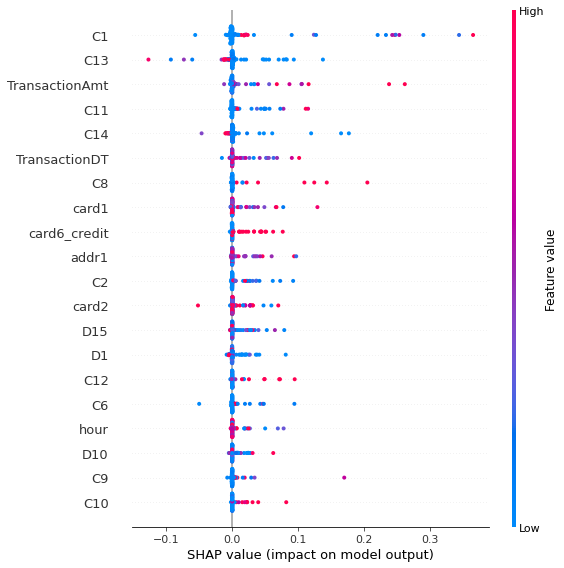

In [31]:
shap.summary_plot(kernel_shap[1], z.to_numpy(), feature_names=feature_names)

Decision plot: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html?highlight=plot

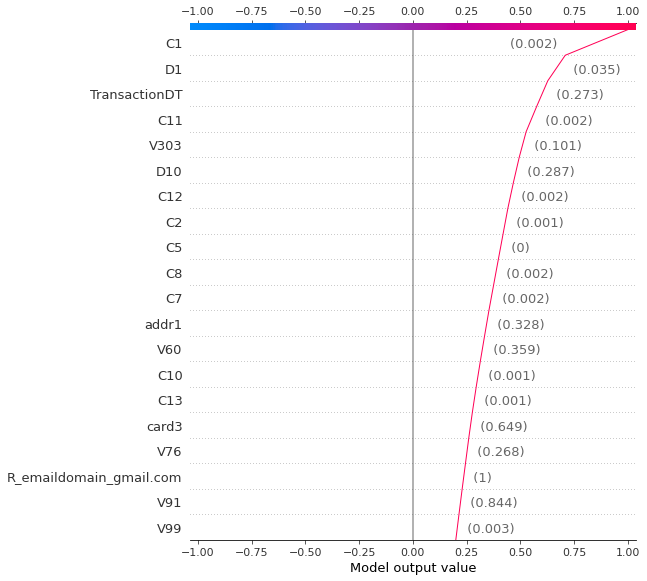

In [32]:
shap.decision_plot(explainer.expected_value[1], kernel_shap[1][0,:], z.to_numpy()[0], feature_names=feature_names.to_list())

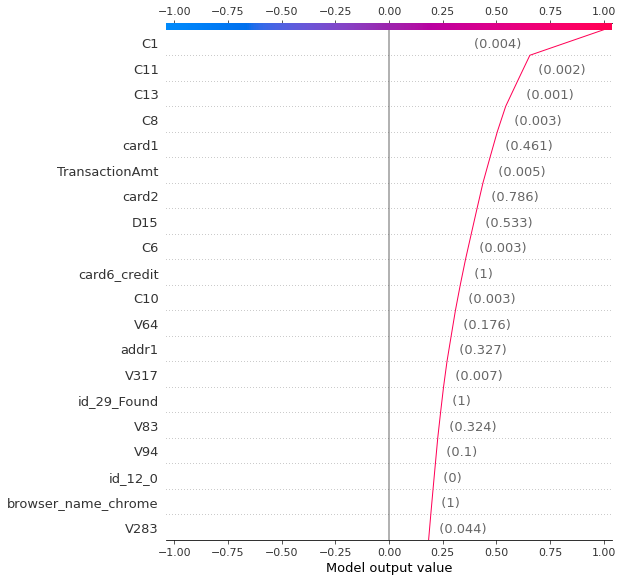

In [33]:
shap.decision_plot(explainer.expected_value[1], kernel_shap[1][1,:], z.to_numpy()[1], feature_names=feature_names.to_list())

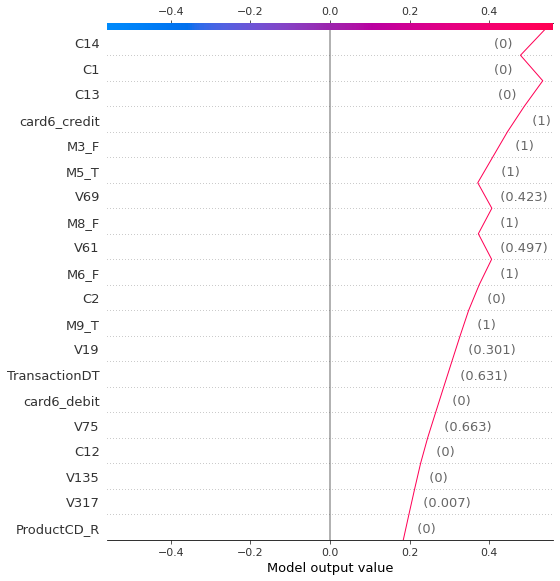

In [34]:
shap.decision_plot(explainer.expected_value[1], kernel_shap[1][2,:], z.to_numpy()[2], feature_names=feature_names.to_list())

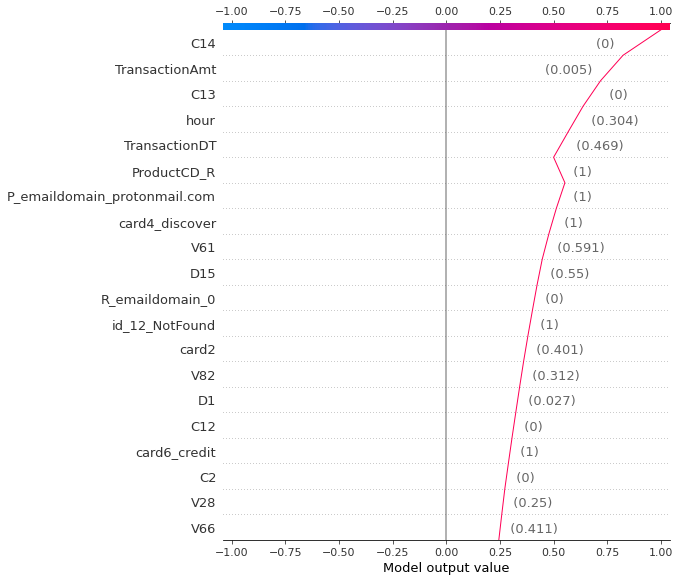

In [35]:
shap.decision_plot(explainer.expected_value[1], kernel_shap[1][3,:],z.to_numpy()[3], feature_names=feature_names.to_list())

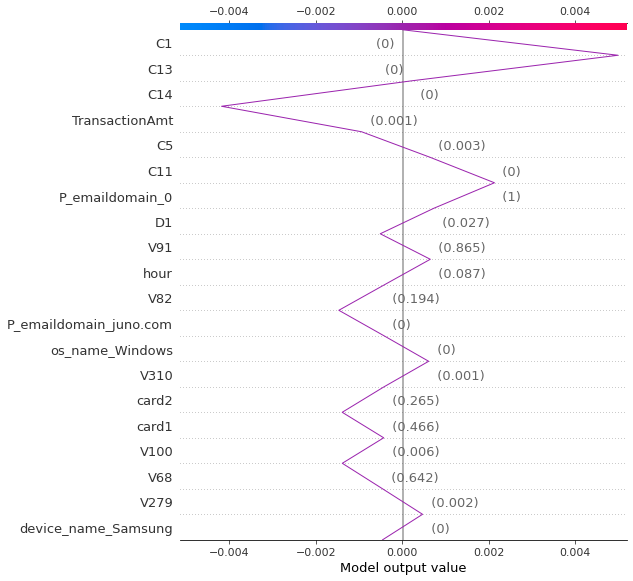

In [36]:
shap.decision_plot(explainer.expected_value[1], kernel_shap[1][-1,:], z.to_numpy()[-1], feature_names=feature_names.to_list())